# Krista, working on linking CO and KO
27 August 2015; 30 September 2015

The KEGG CO numbers from the RI data are not unique. In MATLAB, I have created a new value 'RInumber' which is an arbitrary number for each 'mzRT' feature. The data exported out of MATLAB include that number, the corresponding KEGG CO number, and whether the feature was observed in positive or negative ion mode. These data will be uesd to create a lookup table which allow use of the CO numbers or RInumbers as needed.

In [1]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal
from itertools import chain
from IPython.core.debugger import Tracer #used this to step into the function and debug it, also need line with Tracer()() 

%matplotlib inline

This version is using metabolites which can have isomers in KEGG, but are only found in either positive or negative ion mode (haven't dealt with the metabolites found in both yet). 

Also, will need to export the following from MATLAB
(1) RInumber, (2) CO number, (3) ion mode information

Also, want to move some of my working files out of sight so they don't fill up GitHub. Need to figure out the best way to do that.'

In [2]:
mtabFile = 'RImetabolites_isomers.2015.08.27.csv' #first column is RInumber

In [3]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')
# CO_fromMATLAB=CO_RawData[CO_RawData.sum(axis=1)!=0]
#read in the data from MATLAB and take a quick look
CO_fromMATLAB.head(n=5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5
RInumber,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436


make the list of unique cNumbers here, do the KEGG thing and filter the list before I start splitting up the dataframes into data and metadata...

In [4]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

In [5]:
#wonder whether these should be defined at the top?
import os.path
import cPickle as cpk

This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv file is a unique list of C number we essentially already have a lookup table for all the metabolites of interest.

In [6]:
if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
    #just read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
else:
    #need to make the file
    filename = "CreateHash_COtoKO.py"
    %run $filename exportCOnumbers.csv 
    #then read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))

#WorkingFile = cpk.load(open('exportMetabolites.csv.pickle','r'))


In [7]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'



There are 404 COs with an associated KO. 1438 are not associated with a KO.


In [8]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

# KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
# CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()

In [9]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [10]:
CO_fromMATLAB.head(5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5,inList
RInumber,,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441,False
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436,False


In [11]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of things came in handy, so define it up front. Actually want something that can't change 
#but had trouble getting a tuple to work as an index.
dayList = ['S1','S2','S3','S4','S5'] #this makes a list (mutable, can be changed)
#days = ('S1','S2','S3','S4','S5') #this makes a tuple (immutable)
CO_RawData_pruned = m.loc[:,dayList]
del m

This is the new version, with the extended metadata. Parse the file into data and metadata.

In [12]:
#read in the KO data
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]

Consider various data normalization options here. For now, normalize to mean and move one.

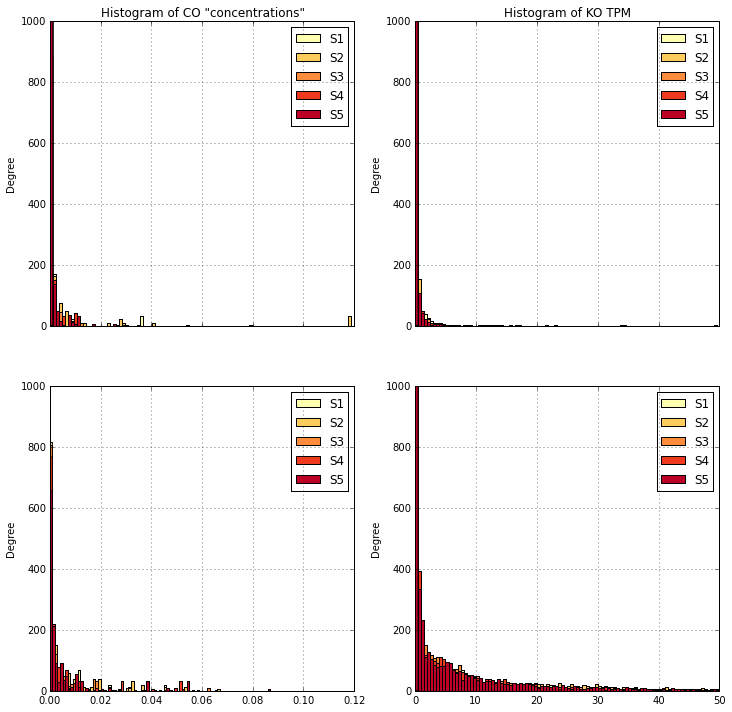

In [13]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData_pruned.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData_pruned.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])

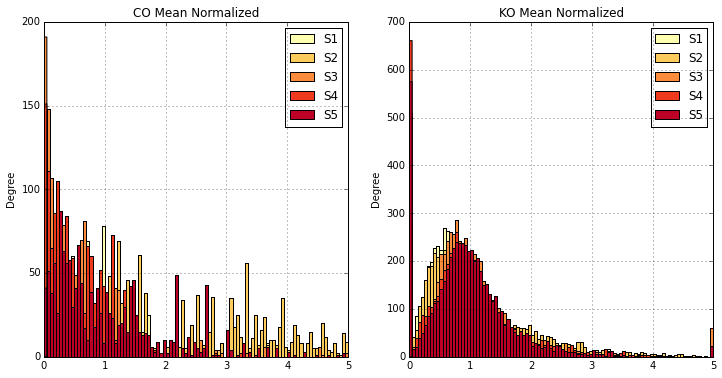

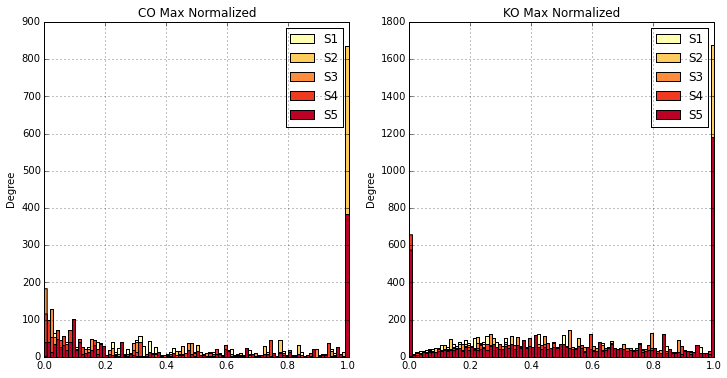

In [14]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData_pruned) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
CO_Norm2Max=NormalizeToMax(CO_RawData_pruned)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

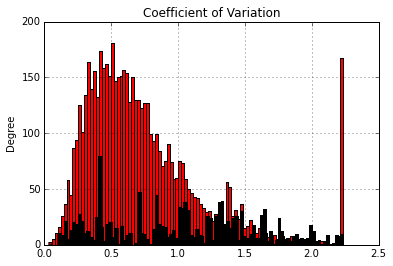

In [15]:
def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData_pruned)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')

In [16]:
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
CO_limited_Norm2Mean = CO_Norm2Mean.dropna() #already 'limited' this before the normalization

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#this next line prints up some sort of pre-canned details about the program. 
print(__doc__) 

def kmeanCluster(data,nc):
    #kmeans=KMeans(n_clusters=nc)
    kmeans = KMeans(n_clusters = nc, max_iter = 1000, n_init = 50, init = 'random')
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):
    ssa = [] #can I put the silhoette average here?
    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
       
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
         #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        plt.show()
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)


Automatically created module for IPython interactive environment


So...how do we actually decide how many clusters are best? Using silhouette analysis, looking for high silhouette_scores. For now I have set this to only look at a few options. However, there are also good silhouette scores with 2-5 clusters as well.

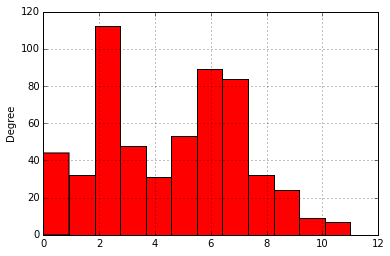

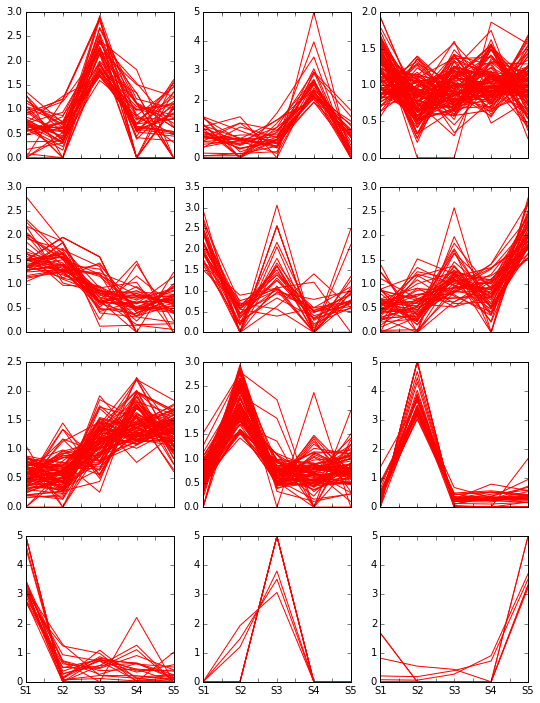

In [18]:
#run the Kmeans clustering on the KO data along first and plot results
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_limited_Norm2Mean, 12)
PlotKmeans(koClust,12,4,3, 'r') 

('For n_clusters =', 11, 'The average silhouette_score is :', 0.37506122653192592)


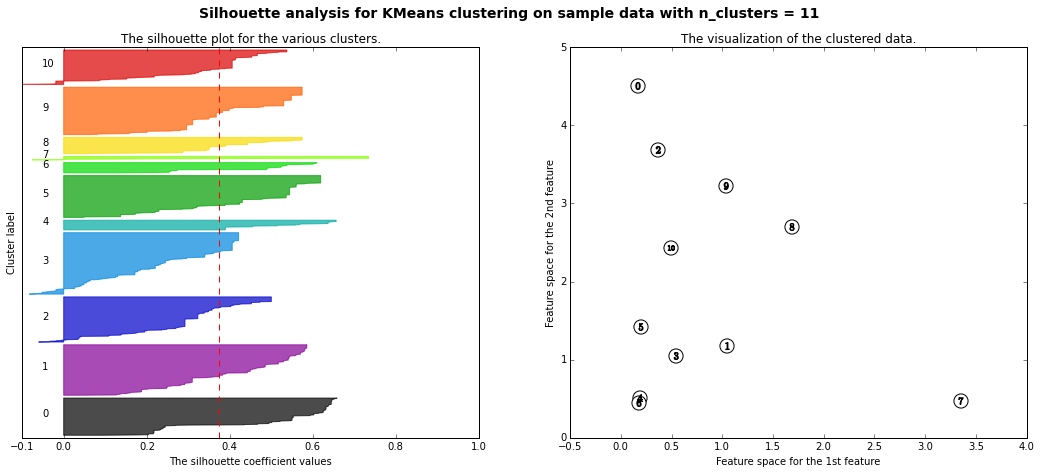

('For n_clusters =', 12, 'The average silhouette_score is :', 0.36187612296380539)


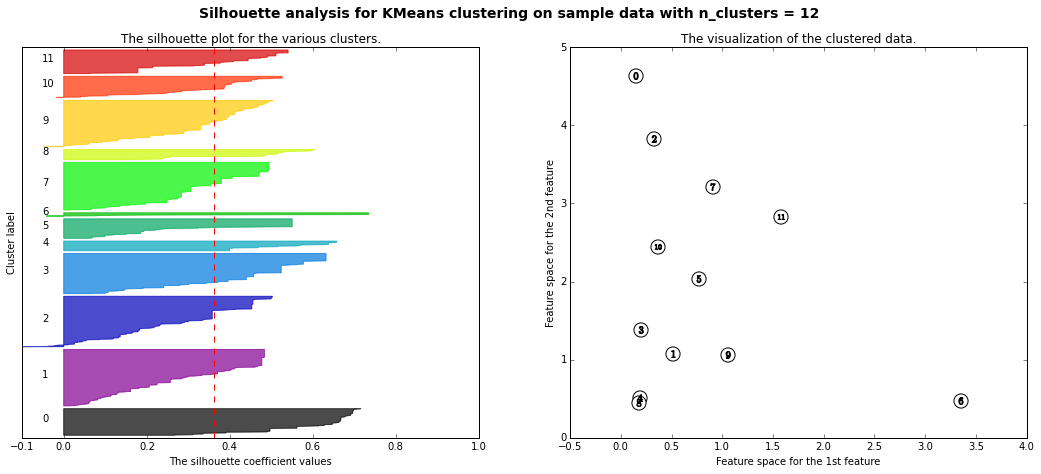

In [19]:
#now do the Kmeans clustering on the CO data
#silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(2,20,1)) #KL trying a large range of options
silhoetteAnalysis(CO_limited_Norm2Mean.loc[:,(dayList)], np.arange(11,13,1))

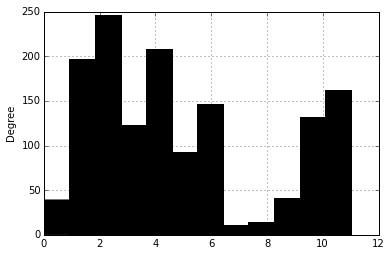

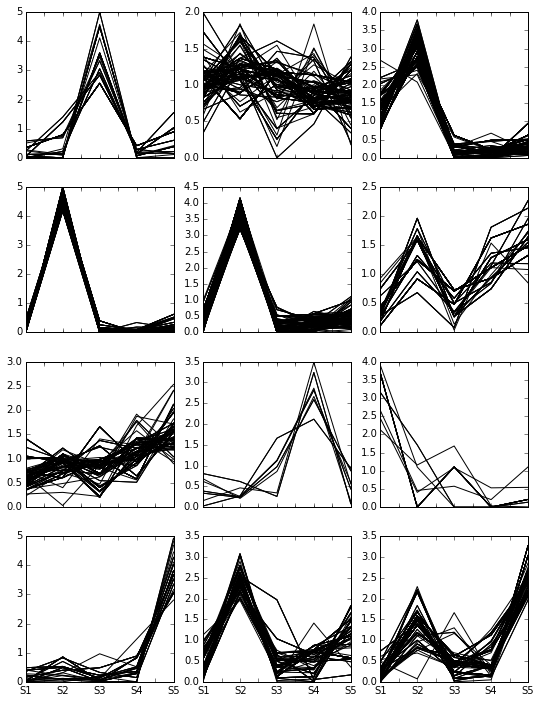

In [20]:
#plot up the results of one number of clusters for the CO data only
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_limited_Norm2Mean.loc[:,(dayList)], 12)
PlotKmeans(coClust,12,4,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis (bc need to set # clusters) and are using the silhouette analysis to do that.

#Do Kmeans on combined CO and KO data

('For n_clusters =', 2, 'The average silhouette_score is :', 0.45872268731003885)


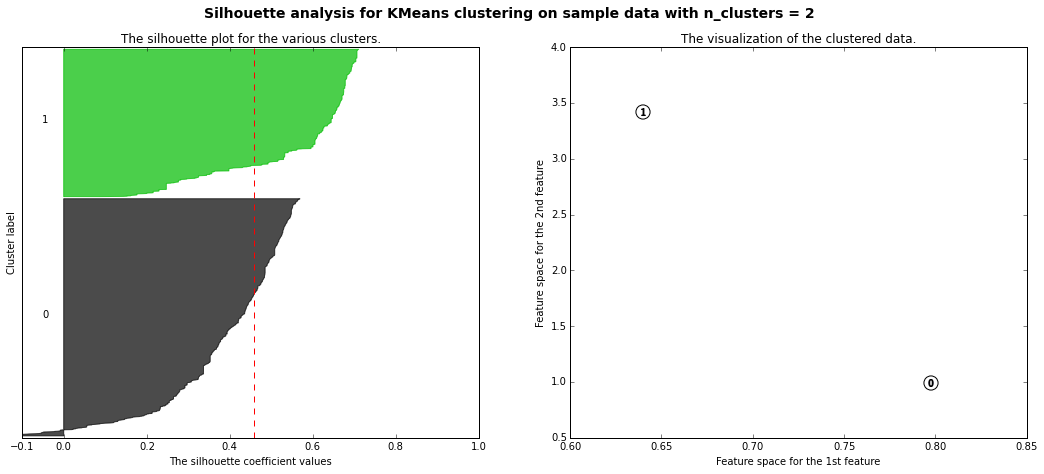

('For n_clusters =', 3, 'The average silhouette_score is :', 0.39652267056936169)


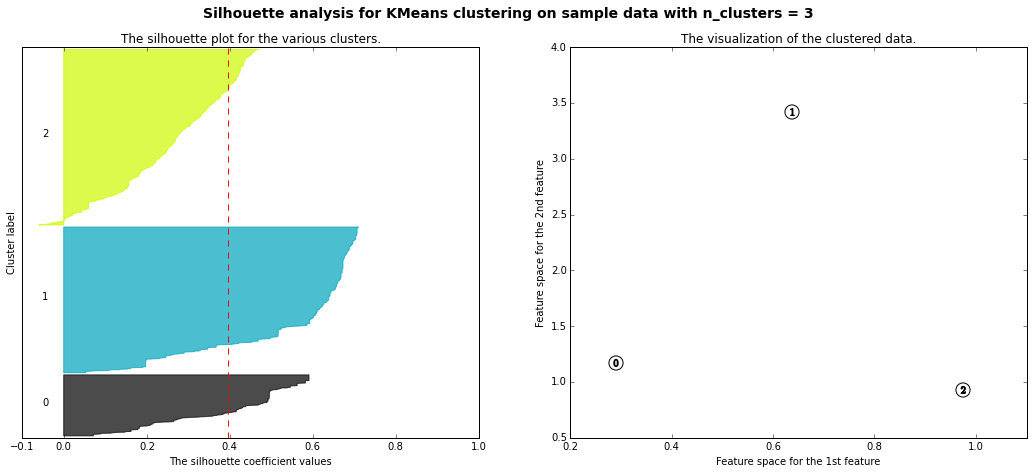

('For n_clusters =', 4, 'The average silhouette_score is :', 0.31952909042980893)


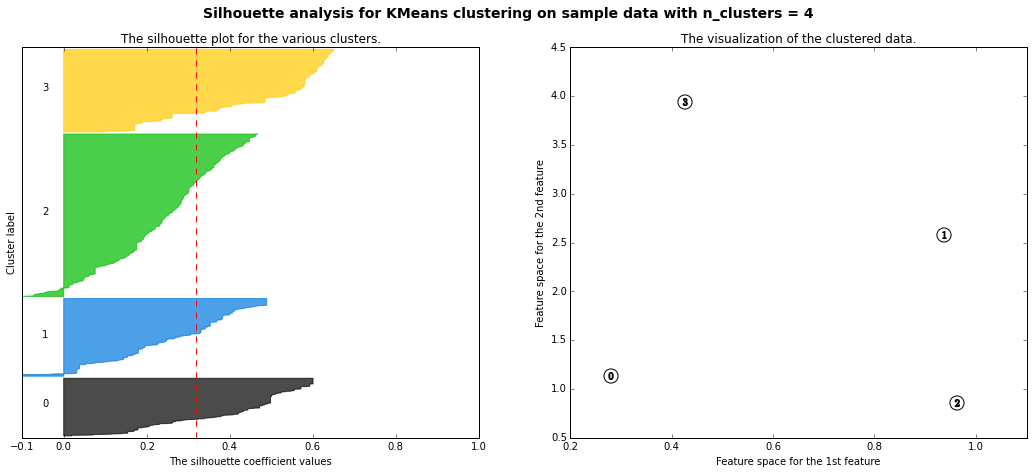

('For n_clusters =', 5, 'The average silhouette_score is :', 0.35074568189569649)


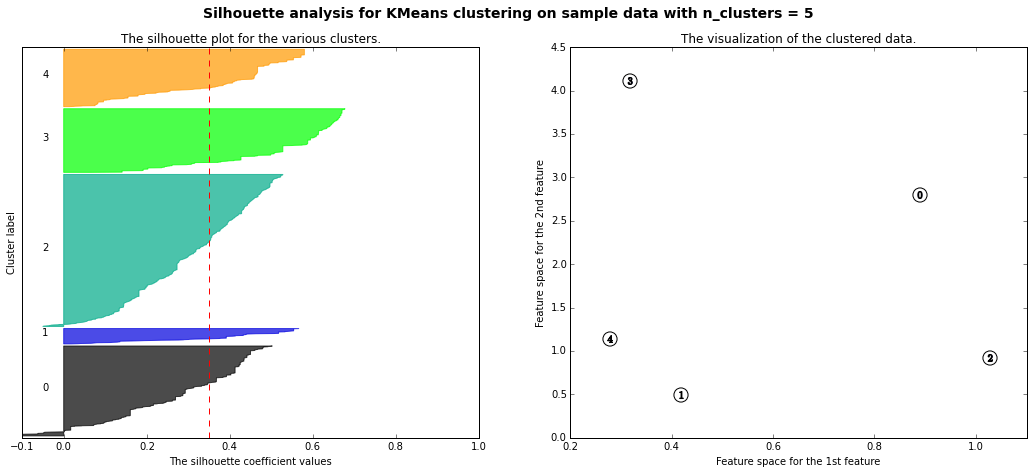

('For n_clusters =', 6, 'The average silhouette_score is :', 0.37266800215487433)


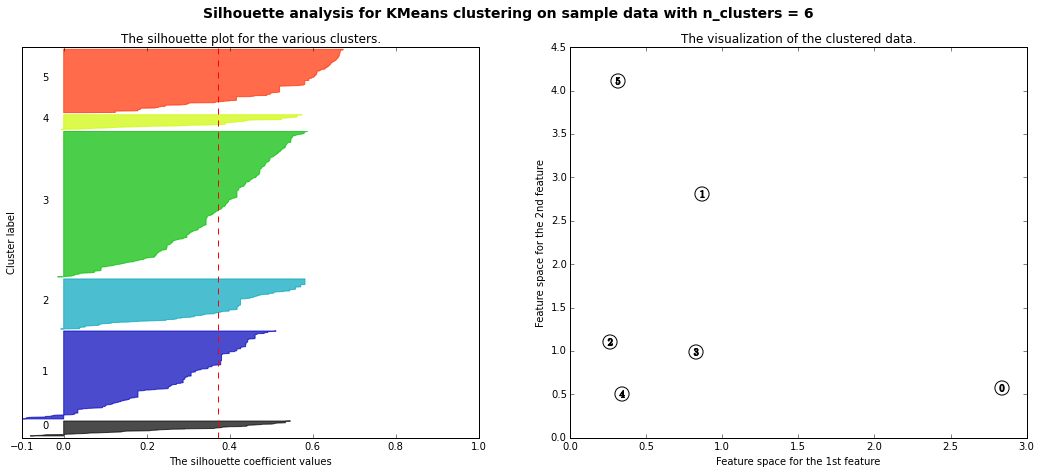

('For n_clusters =', 7, 'The average silhouette_score is :', 0.34401361093717558)


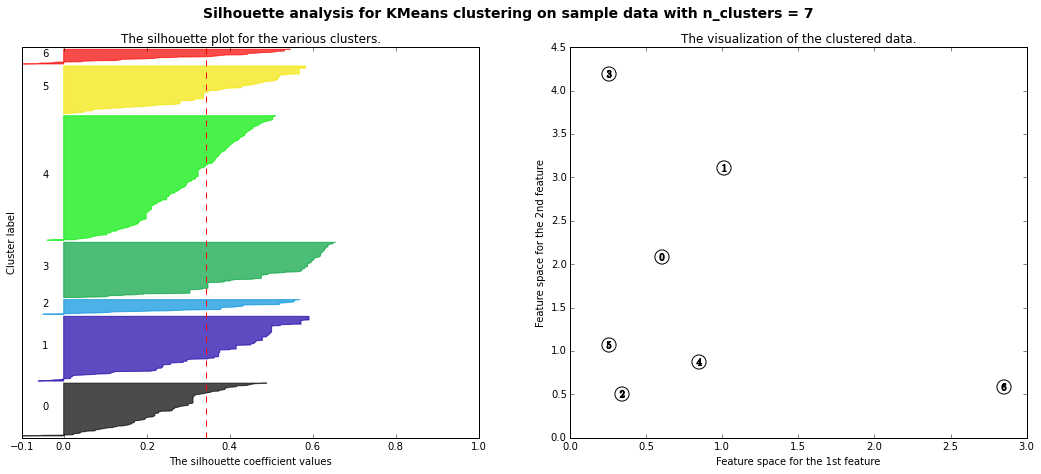

('For n_clusters =', 8, 'The average silhouette_score is :', 0.32938811898640702)


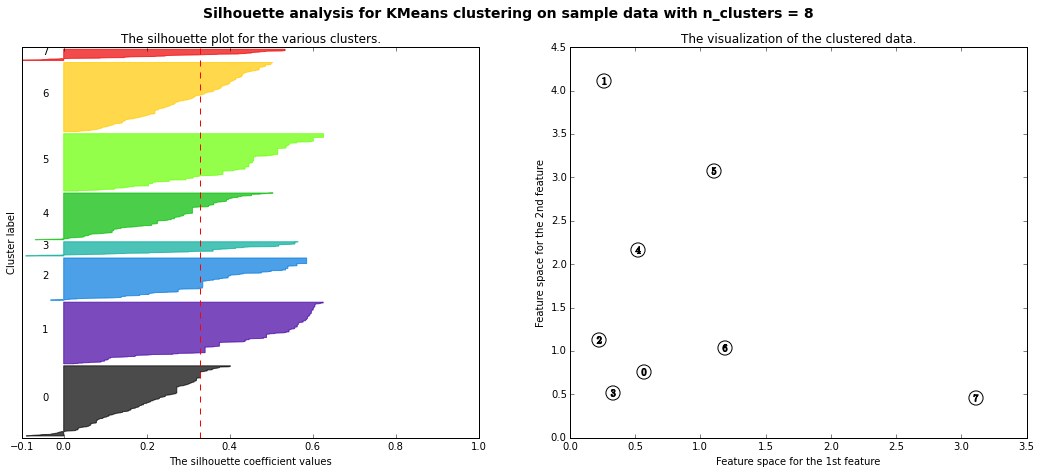

('For n_clusters =', 9, 'The average silhouette_score is :', 0.3334937648421048)


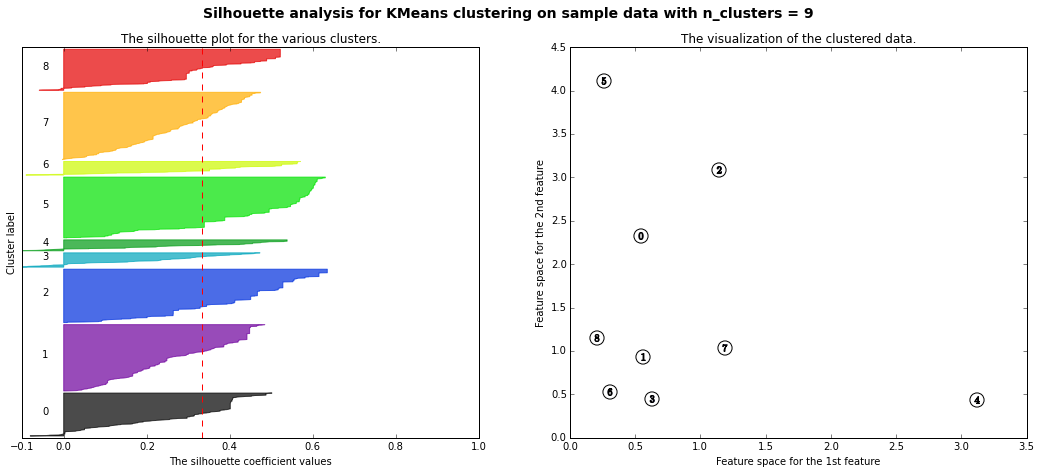

('For n_clusters =', 10, 'The average silhouette_score is :', 0.34066121925181658)


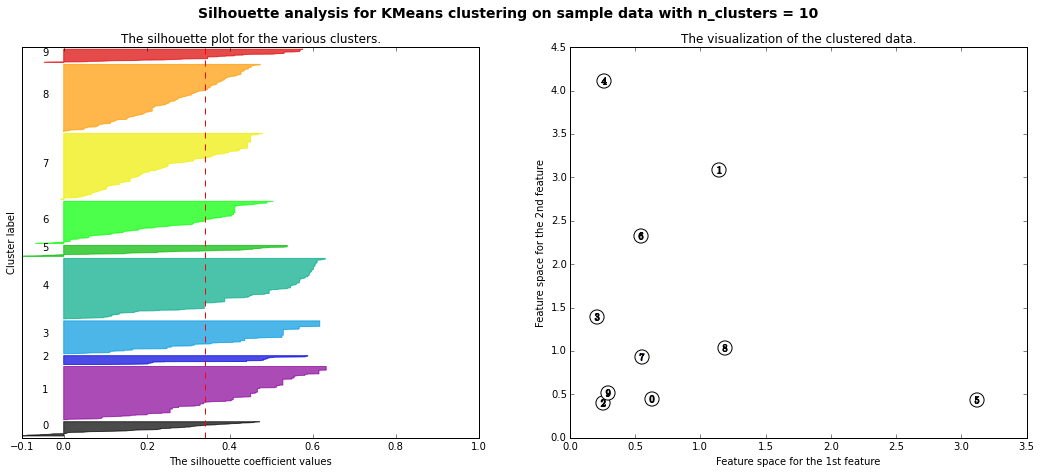

('For n_clusters =', 11, 'The average silhouette_score is :', 0.3262597475613111)


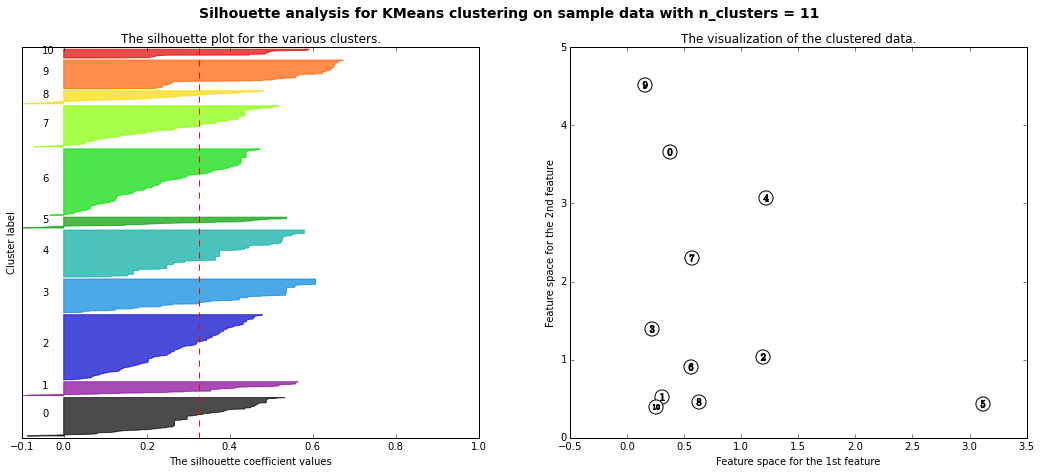

('For n_clusters =', 12, 'The average silhouette_score is :', 0.32665760503583924)


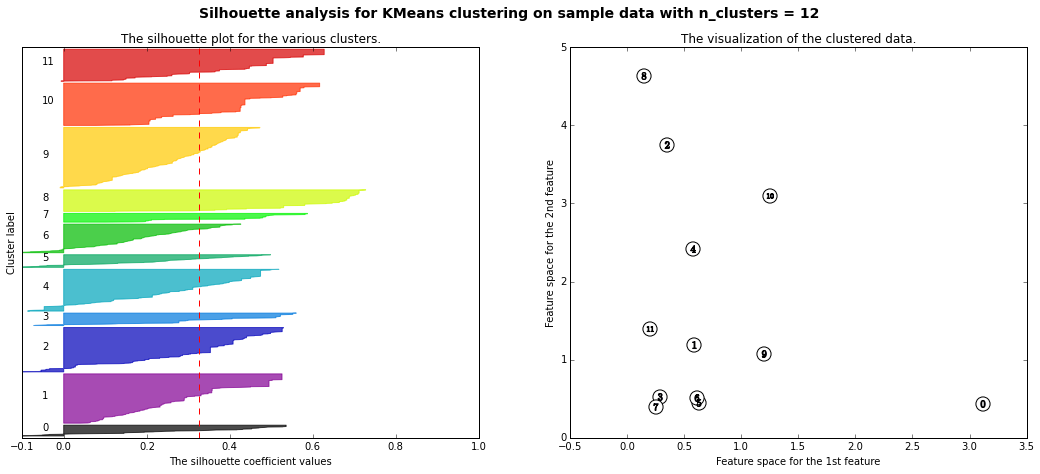

('For n_clusters =', 13, 'The average silhouette_score is :', 0.32823338360700477)


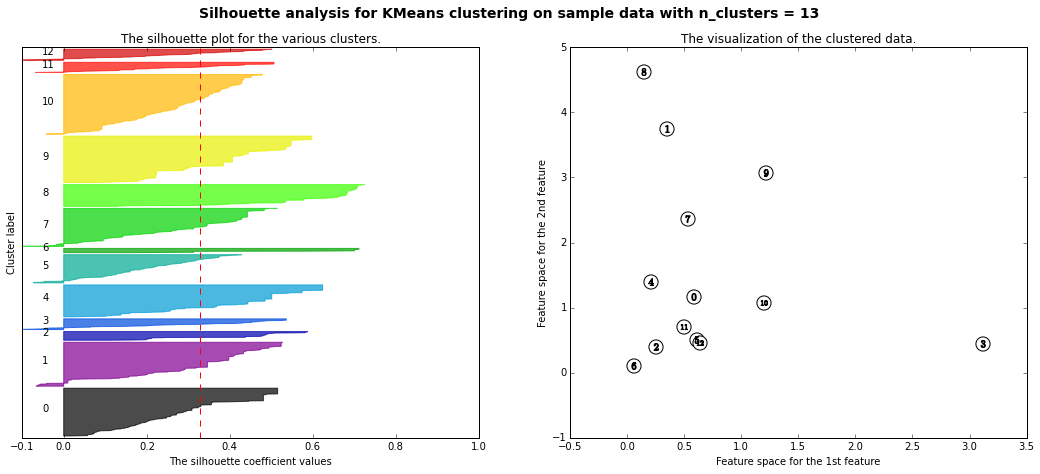

('For n_clusters =', 14, 'The average silhouette_score is :', 0.31514059278542644)


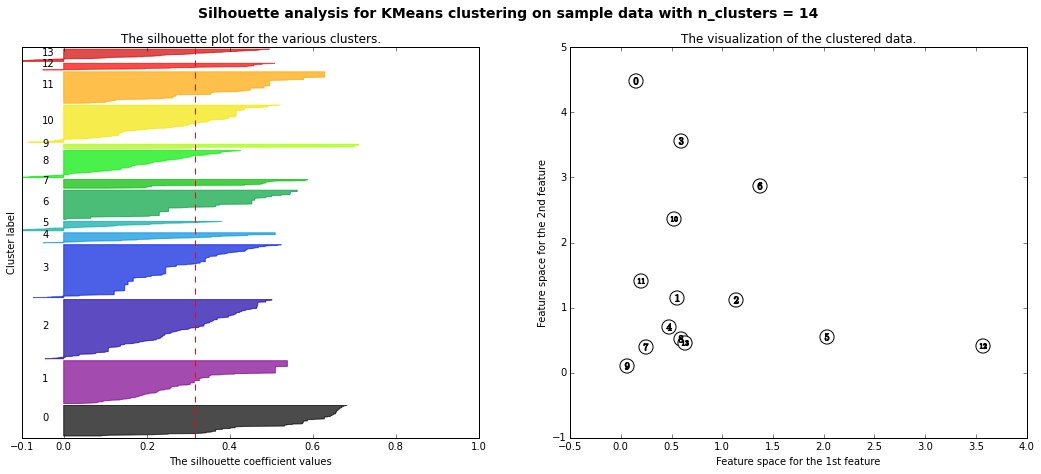

In [21]:
##First, combine the CO and the KO data
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean.loc[:,(dayList)])

#Run silhoette analysis on a range of cluster options
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(2,15,1))

Here I am going with 10 clusters, but I have no actual good reason for that number yet. I tried (and failed) to get the code to spit out the silouette average score...so nabbed the value from the headers (lame)

In [22]:
#completely lame...hand-copied the silhouette scores from the figures
silAverage = [0.43, 0.37, 0.38, 0.40, 0.36, 0.32]

(-1, 20)

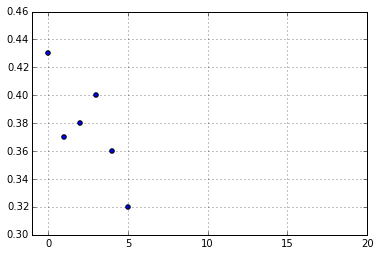

In [23]:
plt.scatter(range(0,len(silAverage)), silAverage)
plt.grid() #put on a grid
plt.xlim(-1,20)

In [24]:
#setting # of clusters manually, also some good options with lower # of clusters I think
#this number will get used later when plotting up the BRITE categories and the Kmeans clusters
makeNclusters = 6

In [25]:
#do the K-means clustering with the final # of clusters
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, makeNclusters) #was 18 

#this will result in a data frame with the kmeans cluster as an added column. Remember
#this will have RI numbers for the compounds

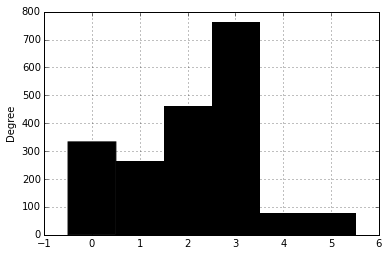

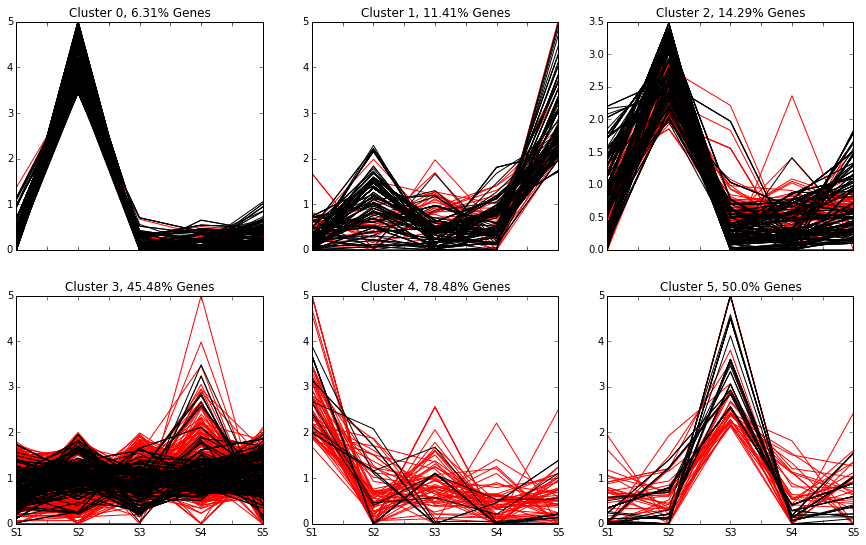

In [26]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k',range = (0,kSize),align = 'left')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title('Cluster ' + str(y)+ ', ' + str(round(KPct,2))+'% Genes')
    fig.savefig('CombinedKOandCO_Kmeans')

PlotKmeansCombined(CcoClust,makeNclusters,2,3, 'r') 

But...for the CheckRelatedness...do need to go back to the cNumber...for now, easiest to just make yet another matrix and put the cNumbers back in. 

In [27]:
forRelatedness = CcoClust.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness.insert(0,'KEGG',"") #add a column called 'KEGG'
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K00509,,0.152509,4.448221,0.125170,0.106221,0.167879,0
K00503,,0.414525,1.336715,0.789500,1.064815,1.394446,3
K00500,,0.382566,2.152637,0.529868,0.425775,1.509153,2
K00505,,1.645125,0.973038,0.940359,0.589700,0.851777,3
K01101,,0.368853,0.611154,0.724593,2.599906,0.695494,3


In [28]:
for idx in range(0,len(forRelatedness)):
    t = forRelatedness.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness.ix[idx,('KEGG')] = t

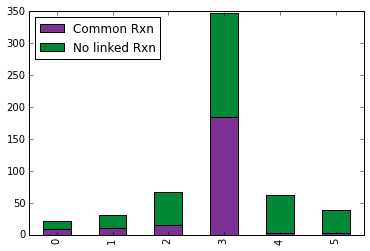

In [29]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
        i=list(i)
        #note...re is one of the things imported at the very beginning
        Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object 
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
     
CheckRelatedness(forRelatedness, makeNclusters)

###Hmm...one thought would be to focus on things with common linked reactions...

Write a couple of functions to swap between CO and RInumbers

In [30]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut

##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

In [31]:
def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

In [32]:
#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value, also uses CO_fromMATLAB as input 

##plot up the data..keeping track of Kmeans group and CO number

In [33]:
#this setups up forPlotting as one, pre-defined Kmeans group
forPlotting = CcoClust[CcoClust.kmeans==2]

In [34]:
forPlotting.shape
#literally put this here to slow down the notebook...I think it is a problem with the
#notebook not finishing up the image plotting before moving on...

(462, 6)

Odd. Sometimes it seems that iPython notebook moves to the next cell before finishing the last one. When this happens, I get empty images? And empty matches...

In [35]:
#this gets around the timing problem.
import time
time.sleep(60)

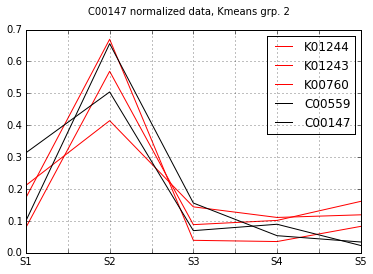

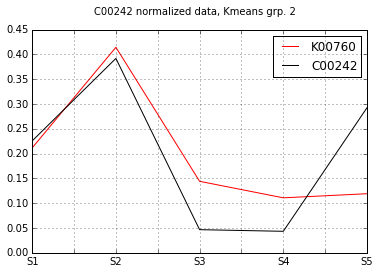

In [36]:
#Start with the simple version
noMatch = []
#will use counter to limit the number of plots, remember skipping over KOnumbers 
#so index would require some guessing as to where the CO plots start
counter = 1 
for i,RI in enumerate(forPlotting.index):
    if counter < 3:
#     if (i >38) & (i < 40):
        if RI[0] == 'R':
            #have an RInumber, go get the Cnumber
            CO = convertRItoCO(CO_fromMATLAB,RI)
            
            #pull the Kmeans group for the title [presumably there is a one-liner for this]
            m = str(forPlotting.ix[i, 'kmeans'])
            Kg = m.rstrip('.0')
            del m 
            
            #there will be multiple (and varied) related KOs and COs
            try:
                kos=CO_withKO[CO]['Related KO']
                cos=CO_withKO[CO]['Related CO'] 

                #the kData are easy to process
                for k in kos: 
                    if k in forPlotting.index: 
                        kData=forPlotting.ix[kos,dayList].dropna()
                        kData=(kData.T/kData.sum(axis=1)).T

                #match the cos here with the RInumbers I generated
                tData = [];
                for c in cos:
                    m = findRInumber(forRelatedness,c)
                    if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
                        tData.append(m)

                #flatten the list...since I don't need the different groups generated by the previous cell
                tData = list(chain.from_iterable(tData))

                cData=forPlotting.ix[tData,dayList].dropna()
                cData=(cData.T/cData.sum(axis=1)).T

                fig, ax=plt.subplots(1)
                kData.T.plot(color='r', ax=ax)
                cData.T.plot(color='k', ax=ax)

                handles, labels = ax.get_legend_handles_labels()
                #convert the RI numbers to COnumbers for the figure
                for ia, a in enumerate(labels):
                    if a[0]=='R':
#                         Tracer()()
                        m = convertRItoCO(CO_fromMATLAB,a)
                        labels[ia] = m
                        #print i, m

                ax.legend(handles, labels)        
                fig.suptitle(CO + ' normalized data, Kmeans grp. ' + str(Kg))
                #fig.savefig(CO+'.png')
                counter = counter + 1
            except:
                #figure out later why some of these don't have a match
                noMatch.append(CO)

In [37]:
#not sure why I have no matches here...seems to be related to the notebook moving forward too fast?
#in other words, if I go through the code one cell at a time, I get everything matching...what on earth?
#this should be empty:
noMatch

[]

##now make the complicated figures

For the moment, this script pulls the information I use in the label from a Beautiful Soup result. Super inefficient, but leave for the moment.

In [38]:
#this setups up forPlotting as one, pre-defined Kmeans group. 
# Probably not a good idea to run all groups at once since that is ~2000 plots. 
#forPlotting = CcoClust.copy(deep = True)
forPlotting = CcoClust[CcoClust.kmeans==3]

In [39]:
forPlotting.shape

(763, 6)

In [40]:
#can set to 'if false' to skip over this cell, generally a good idea since this requires Beautiful Soup & KEGG
#which at times can be super slow
#or use counter to only plot a few examples
if False:
    noMatch = []
    #will use counter to limit the number of plots, remember skipping over KOnumbers 
    #so index would require some guessing as to where the CO plots start
    counter = 1 
    for i,RI in enumerate(forPlotting.index):
        if counter < 3:
            if RI[0] == 'R':
                #have an RInumber, go get the Cnumber
                CO = convertRItoCO(CO_fromMATLAB,RI)

                #pull the Kmeans group for the title [presumably there is a one-liner for this]
                m = str(forPlotting.ix[i, 'kmeans'])
                Kg = m.rstrip('.0')
                del m 

                #there will be multiple (and varied) related KOs and COs
                try:
                    kos=CO_withKO[CO]['Related KO']
                    cos=CO_withKO[CO]['Related CO'] 

                    #the kData are easy to process
                    for k in kos: 
                        if k in forPlotting.index: 
                            kData=forPlotting.ix[kos,dayList].dropna()
                            kData=(kData.T/kData.sum(axis=1)).T

                    #match the cos here with the RInumbers I generated
                    tData = [];
                    for c in cos:
                        m = findRInumber(forRelatedness,c)
                        if len(m)!=0: #seems dumb, looking for an isempty equivalent since I don't want the nones here
                            tData.append(m)

                    #flatten the list...since I don't need the different groups generated by the previous cell
                    tData = list(chain.from_iterable(tData))

                    cData=forPlotting.ix[tData,dayList].dropna()
                    cData=(cData.T/cData.sum(axis=1)).T

                    counter = counter + 1
                    fig = plt.figure()
                    ax1 = fig.add_subplot(121)
                    #ax2 = fig.add_subplot(122)

                    kData.T.plot(color='r', ax=ax1)
                    cData.T.plot(color='k', ax=ax1)

                    handles, labels = ax1.get_legend_handles_labels()
                    #convert the RI numbers to COnumbers for the figure

                    for ia, a in enumerate(labels):
                        if a[0]=='R':
                            m = convertRItoCO(CO_fromMATLAB,a)
                            CO_httpstr='http://www.genome.jp/dbget-bin/www_bget?cpd:'
                            CO_httpfull=CO_httpstr+m
                            COsite=urllib2.urlopen(CO_httpfull)
                            Csoup = BeautifulSoup(COsite)
                            results = Csoup.find("td",{"class":"td21"})
                            for cell in results:
                                t = results.getText(strip=True)
                                labels[ia] = m + ', ' + str(t)
                        elif a[0] =='K':
                            KO_httpstr='http://www.genome.jp/dbget-bin/www_bget?ko:'
                            KOsite=urllib2.urlopen(KO_httpstr+a)
                            Ksoup=BeautifulSoup(KOsite)
                            results = Ksoup.find_all("td",{"class":"td40"})
                            for i, cell in enumerate(results):
                                if i==1:
                                    t = cell.get_text(strip = True)
                                    labels[ia] = a + ', ' + str(t)

                    ax1.legend(handles, labels)           
                    fig.suptitle(CO + ', Kmeans grp ' + Kg)

                    #fig.savefig(CO+'.png')               
                except:
                    #figure out later why some of these don't have a match
                    noMatch.append(CO)

###1 September 2015, KL notes
I used Compounds_BRITEhierarchy.ipynb to get the BRITE information for the compounds. Probably would be easier if that is a .py file

In [41]:
cBRITE = cpk.load(open('BRITE_compoundsOnly.pickle','rb'))

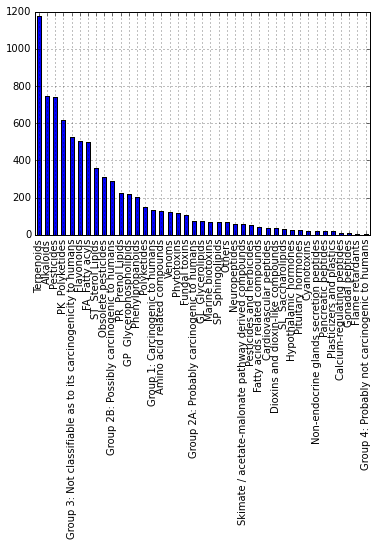

In [42]:
justC = cBRITE['A']
justC.value_counts().plot(kind = 'bar')
#this is all the compounds in the cBRITE list...

next up: for each BRITE group, plot the number of compounds from each Kmeans cluster. Is anything overrepresented?

In [43]:
cBRITE['kmeans'] = float('NaN')

In [44]:
cBRITE.head(5)

,cNumber,A,B,C,D,wholeThing,kmeans
8,NaN,FA Fatty acyls,NaN,NaN,NaN,A<b>FA Fatty acyls</b>\n,NaN
9,NaN,FA Fatty acyls,FA01 Fatty Acids and Conjugates,NaN,NaN,B FA01 Fatty Acids and Conjugates\n,NaN
10,NaN,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,NaN,C FA0101 Straight chain fatty acids\n,NaN
11,C00058,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,NaN,D C00058 Formic acid\n,NaN
12,C00033,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,NaN,D C00033 Acetic acid\n,NaN


In [45]:
#go find each cNumber in CcoClust...get the kmeans group
for row in CcoClust.iterrows():
    RI = row[0]
    if RI[0] == 'R':
        CO = convertRItoCO2(RI)
        tData = CcoClust.loc[RI] 
        km = tData.kmeans
        #so, now I have CO number and the kmeans cluster number. Put that into cBRITE
        k = cBRITE[cBRITE.cNumber == CO]
        cBRITE.loc[k.index,'kmeans'] = km
 

In [46]:
#only want columns when kmeans is not empty...remember kmeans starts at 0
justC = cBRITE.dropna(subset = ['kmeans'])
#reindex otherwise I have wierd case with multiple instances of the same index...don't quite get that
justC.index = range(len(justC))

In [47]:
justC.head(5)

,cNumber,A,B,C,D,wholeThing,kmeans
0,C06423,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,NaN,D C06423 Octanoic acid\n,3
1,C00671,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,NaN,D C00671 (S)-3-Methyl-2-oxopentanoic acid\n,1
2,C04181,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,NaN,D C04181 3-Hydroxy-3-methyl-2-oxobutanoi...,1
3,C16651,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,NaN,D C16651 3-Hydroxyvalproic acid\n,3
4,C16649,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,NaN,D C16649 4-Hydroxyvalproic acid\n,3


In [49]:
countByBRITE = justC.loc[:,['A','B','C']]
source_cols = countByBRITE.columns
#useClusters is the value set above that fixes the # of Kmeans clusters.
new_cols = ["Km" + str(x) for x in range(makeNclusters)]
new_cols

['Km0', 'Km1', 'Km2', 'Km3', 'Km4', 'Km5']

In [50]:
for x in new_cols:
    countByBRITE[x] = 0
    
countByBRITE.drop_duplicates(inplace = True) #inplace = True lets me keep the variable 
#reassign the index to make this easier (or at least reduce my own confusion)
countByBRITE.index = range(len(countByBRITE))
countByBRITE.head(5)

,A,B,C,Km0,Km1,Km2,Km3,Km4,Km5
0,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,0,0,0,0,0,0
1,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,0,0,0,0,0,0
2,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0104 Hydroperoxy fatty acids,0,0,0,0,0,0
3,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0105 Hydroxy fatty acids,0,0,0,0,0,0
4,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0106 Oxo fatty acids,0,0,0,0,0,0


In [51]:
# #somewhere around here I think I am making an indexing error
# ###I don't know if I end up using this...in the counting loop
# tf = pd.DataFrame(columns = new_cols) #make empty data frame 
# pd.merge(countByBRITE,tf) #merge data frames

In [52]:
for tIdx in range(len(countByBRITE)):
# for tIdx in (93,94):
    oneRow = countByBRITE.loc[tIdx,'A':'C']
    t = tuple(oneRow)
    keepRow = [] #just keep the row index, as a list for each tuple
    for idx,row in justC.iterrows():
        #good grief, iterrows is SLOW, must be a better way...
        if (justC.loc[idx,'A'] is t[0]) and (justC.loc[idx,'B'] is t[1]) and (justC.loc[idx,'C'] is t[2]):
            keepRow.append(idx)  
    getOne = justC.loc[keepRow,'kmeans']     
    fillCount = getOne.value_counts(sort = True)
    #need to convert the numeric values for the Kmeans into my new string names...
    cMatch  = []
    for idx2,row2 in enumerate(fillCount):
        fk = fillCount.index[idx2]
        cMatch.extend(["Km" + str(int(fk))])

    fillCount.index = cMatch
    # now put the count information into the ou data frame
    countByBRITE.loc[tIdx,fillCount.index] = fillCount

In [53]:
from stackedBarGraph import StackedBarGrapher
SBG = StackedBarGrapher()

In [54]:
countByBRITE.head(5)

,A,B,C,Km0,Km1,Km2,Km3,Km4,Km5
0,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,0,0,0,1,0,0
1,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,3,2,0,3,0,0
2,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0104 Hydroperoxy fatty acids,1,3,0,0,0,1
3,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0105 Hydroxy fatty acids,0,1,1,4,0,1
4,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0106 Oxo fatty acids,1,1,0,4,0,0


In [55]:
#now I have a mix of NaNs and 0...not sure how I managed that, but for the moment, change NaN to 0
countByBRITE = countByBRITE.fillna(value = 0)

In [56]:
countByBRITE.head(5)

,A,B,C,Km0,Km1,Km2,Km3,Km4,Km5
0,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0101 Straight chain fatty acids,0,0,0,1,0,0
1,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0102 Branched fatty acids,3,2,0,3,0,0
2,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0104 Hydroperoxy fatty acids,1,3,0,0,0,1
3,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0105 Hydroxy fatty acids,0,1,1,4,0,1
4,FA Fatty acyls,FA01 Fatty Acids and Conjugates,FA0106 Oxo fatty acids,1,1,0,4,0,0


In [57]:
new_cols

['Km0', 'Km1', 'Km2', 'Km3', 'Km4', 'Km5']

In [58]:
s = countByBRITE[(countByBRITE.loc[:,new_cols].values > 3).any(axis=1)]
dataToPlot = s.loc[:,new_cols]

In [62]:
#this seems dumb and roundabout
oneList = pd.np.array(s.loc[:,'C'])

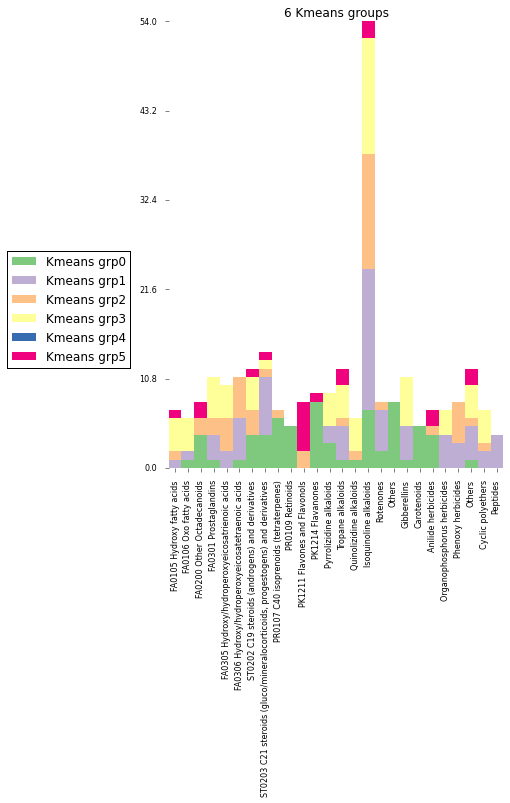

In [64]:
# d_widths = [.5,1.,3.,2.,1.,2.,5.,4.]
#d_labels = ["fred","julie","sam","peter","rob","baz"]
#d_labels = oneList

d_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0','#f0027f']
# d_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',
#             '#6a3d9a','#ffff99','#b15928']

fig = plt.figure(figsize=(6,8)) #setting this here keeps the x-axis labels in the actual figure
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)
SBG.stackedBarPlot(ax,
                   dataToPlot,
                   d_colors,
                   xLabels=oneList,
                   )
#add the legend, first need to assemble it
fL = [];
for i in range(len(dataToPlot.columns)):
    fL.append('Kmeans grp' + str(i))
    
# ax.legend(fL,loc='upper left',bbox_to_anchor=(1,0.5))
leg = ax.legend(fL,loc='upper left',bbox_to_anchor=([-0.5, 0.5]))
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=20, alpha=a)
leg.get_title().set_position((0, 10))


# ax.legend(fL,loc = 'best')

plt.title("6 Kmeans groups")

#fig.savefig('stackedBar'+'.png',bbox_inches = 'tight') #adding bbox_inches finally gets everything exported
plt.savefig('exportFigABC.eps', format='eps', dpi=1000,bbox_inches = 'tight')

In [65]:
countByBRITE = justC.loc[:,['A','B']]
source_cols = countByBRITE.columns
#useClusters is the value set above that fixes the # of Kmeans clusters.
new_cols = ["Km" + str(x) for x in range(makeNclusters)]

In [66]:
for x in new_cols:
    countByBRITE[x] = 0
    
countByBRITE.drop_duplicates(inplace = True) #inplace = True lets me keep the variable 
#reassign the index to make this easier (or at least reduce my own confusion)
countByBRITE.index = range(len(countByBRITE))

In [67]:
for tIdx in range(len(countByBRITE)):
# for tIdx in (93,94):
    oneRow = countByBRITE.loc[tIdx,'A':'B']
    t = tuple(oneRow)
    keepRow = [] #just keep the row index, as a list for each tuple
    for idx,row in justC.iterrows():
        #good grief, iterrows is SLOW, must be a better way...
        if (justC.loc[idx,'A'] is t[0]) and (justC.loc[idx,'B'] is t[1]):
            keepRow.append(idx)  
    getOne = justC.loc[keepRow,'kmeans']     
    fillCount = getOne.value_counts(sort = True)
    #need to convert the numeric values for the Kmeans into my new string names...
    cMatch  = []
    for idx2,row2 in enumerate(fillCount):
        fk = fillCount.index[idx2]
        cMatch.extend(["Km" + str(int(fk))])

    fillCount.index = cMatch
    # now put the count information into the ou data frame
    countByBRITE.loc[tIdx,fillCount.index] = fillCount

In [68]:
#only plot those that have #s >3
s = countByBRITE[(countByBRITE.loc[:,new_cols].values > 3).any(axis=1)]
dataToPlot = s.loc[:,new_cols]

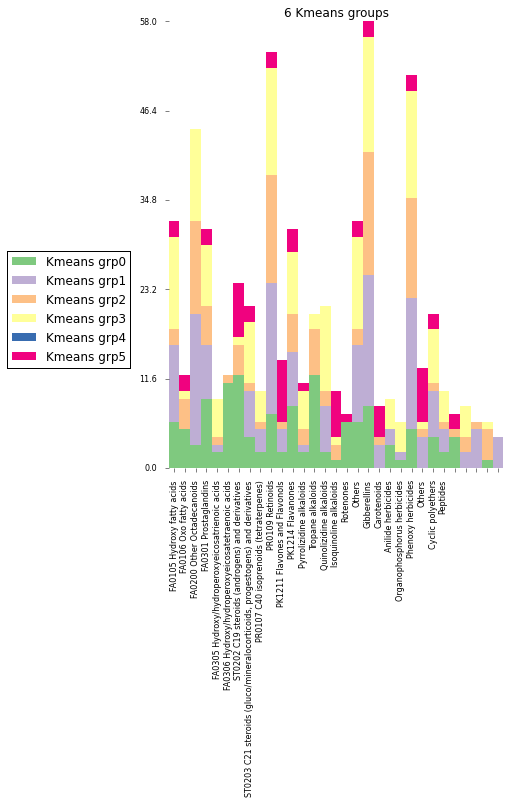

In [69]:
d_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0','#f0027f']

fig = plt.figure(figsize=(6,8)) #setting this here keeps the x-axis labels in the actual figure
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)
SBG.stackedBarPlot(ax,
                   dataToPlot,
                   d_colors,
                   xLabels=oneList,
                   )
#add the legend, first need to assemble it
fL = [];
for i in range(len(dataToPlot.columns)):
    fL.append('Kmeans grp' + str(i))
    
# ax.legend(fL,loc='upper left',bbox_to_anchor=(1,0.5))
leg = ax.legend(fL,loc='upper left',bbox_to_anchor=([-0.5, 0.5]))
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=20, alpha=a)
leg.get_title().set_position((0, 10))


# ax.legend(fL,loc = 'best')

plt.title("6 Kmeans groups")

#fig.savefig('stackedBar'+'.png',bbox_inches = 'tight') #adding bbox_inches finally gets everything exported
plt.savefig('exportFigAB.eps', format='eps', dpi=1000,bbox_inches = 'tight')

In [70]:
countByBRITE = justC.loc[:,['A']]
source_cols = countByBRITE.columns
#useClusters is the value set above that fixes the # of Kmeans clusters.
new_cols = ["Km" + str(x) for x in range(makeNclusters)]

In [71]:
for x in new_cols:
    countByBRITE[x] = 0
    
countByBRITE.drop_duplicates(inplace = True) #inplace = True lets me keep the variable 
#reassign the index to make this easier (or at least reduce my own confusion)
countByBRITE.index = range(len(countByBRITE))

In [72]:
for tIdx in range(len(countByBRITE)):
# for tIdx in (93,94):
    oneRow = countByBRITE.loc[tIdx,'A'] 
    #change for only one column
    #t = tuple(oneRow)
    t = (oneRow,)
    keepRow = [] #just keep the row index, as a list for each tuple
    for idx,row in justC.iterrows():
        #good grief, iterrows is SLOW, must be a better way...
        if (justC.loc[idx,'A'] is t[0]):
            keepRow.append(idx)  
    getOne = justC.loc[keepRow,'kmeans']     
    fillCount = getOne.value_counts(sort = True)
    #need to convert the numeric values for the Kmeans into my new string names...
    cMatch  = []
    for idx2,row2 in enumerate(fillCount):
        fk = fillCount.index[idx2]
        cMatch.extend(["Km" + str(int(fk))])

    fillCount.index = cMatch
    # now put the count information into the ou data frame
    countByBRITE.loc[tIdx,fillCount.index] = fillCount

In [73]:
s = countByBRITE[(countByBRITE.loc[:,new_cols].values > 3).any(axis=1)]
dataToPlot = s.loc[:,new_cols]

In [74]:
#this seems dumb and roundabout
oneList = pd.np.array(s.loc[:,'A'])

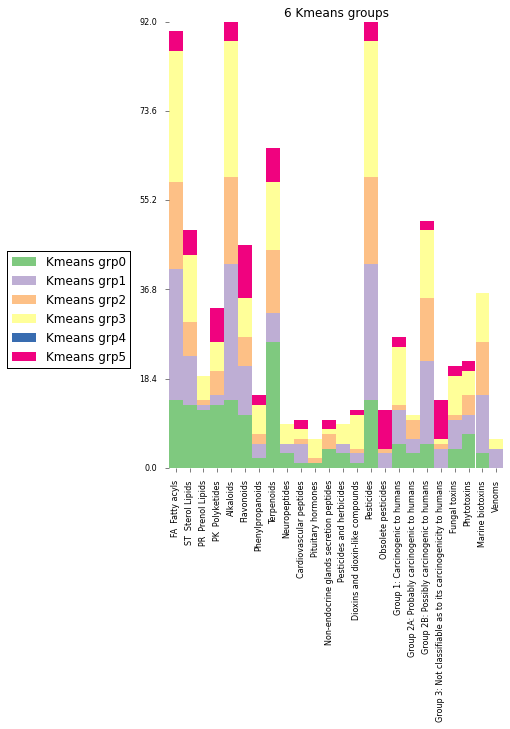

In [75]:
d_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0','#f0027f']

fig = plt.figure(figsize=(6,8)) #setting this here keeps the x-axis labels in the actual figure
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)
SBG.stackedBarPlot(ax,
                   dataToPlot,
                   d_colors,
                   xLabels=oneList,
                   )
#add the legend, first need to assemble it
fL = [];
for i in range(len(dataToPlot.columns)):
    fL.append('Kmeans grp' + str(i))
    
# ax.legend(fL,loc='upper left',bbox_to_anchor=(1,0.5))
leg = ax.legend(fL,loc='upper left',bbox_to_anchor=([-0.5, 0.5]))
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=20, alpha=a)
leg.get_title().set_position((0, 10))


# ax.legend(fL,loc = 'best')

plt.title("6 Kmeans groups")

#fig.savefig('stackedBar'+'.png',bbox_inches = 'tight') #adding bbox_inches finally gets everything exported
plt.savefig('exportFigA.eps', format='eps', dpi=1000,bbox_inches = 'tight')